In [ ]:
整合所有函数，完成车辆检测

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
'''定义一个在图片上画bounding boxes的函数'''
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick) 
    
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes


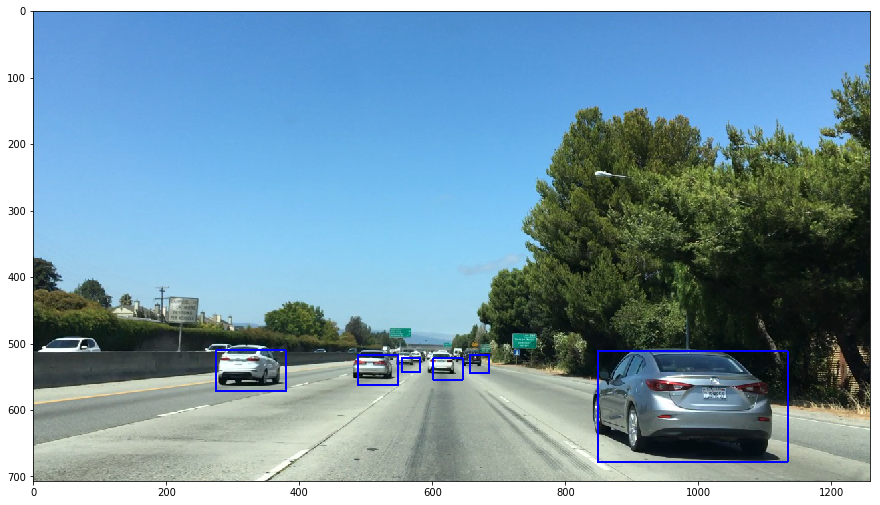

In [3]:
image = mpimg.imread('bbox-example-image.jpg')

# Add bounding boxes in this format, these are just example coordinates.
# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

result = draw_boxes(image, bboxes)
plt.figure(figsize=(15.0, 10.0))
plt.imshow(result)

In [4]:
'''使用模板匹配的方法，匹配检测出特定车辆，并返回对应的box'''
#获取模板图片列表
import glob
templist =glob.glob('cutouts/cutout*.jpg')
print(templist)

['cutouts\\cutout1.jpg', 'cutouts\\cutout2.jpg', 'cutouts\\cutout3.jpg', 'cutouts\\cutout4.jpg', 'cutouts\\cutout5.jpg', 'cutouts\\cutout6.jpg']


In [5]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes for matched templates
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    imcopy =np.copy(img)
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    # Read in templates one by one
    # Use cv2.matchTemplate() to search the image using whichever of the OpenCV search methods you prefer
    # Use cv2.minMaxLoc() to extract the location of the best match
    # Determine bounding box corners for the match
    # Return the list of bounding boxes
    
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    for image in template_list:        
        template = cv2.imread(image)
        w, h = (template.shape[1], template.shape[0])
        #w, h  = template.shape[::-1]
        
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(imcopy,template,cv2.TM_CCOEFF_NORMED)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val,max_val,min_loc,max_loc = cv2.minMaxLoc(result)        
    
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
       # Append bbox position to list
       # Return the list of bounding boxes     
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))
    
    return bbox_list


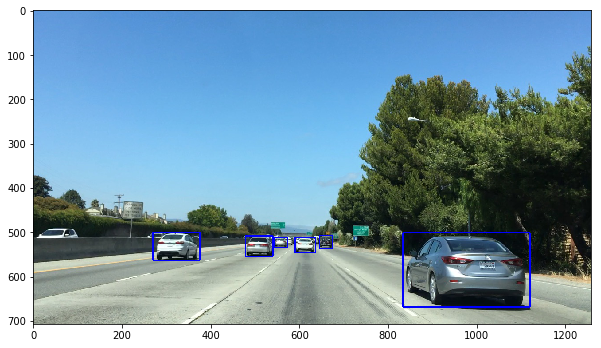

In [6]:
image = mpimg.imread('bbox-example-image.jpg')# Read a color image

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.figure(figsize=(10.0, 8.0))
plt.imshow(result)

(63, 106, 3)


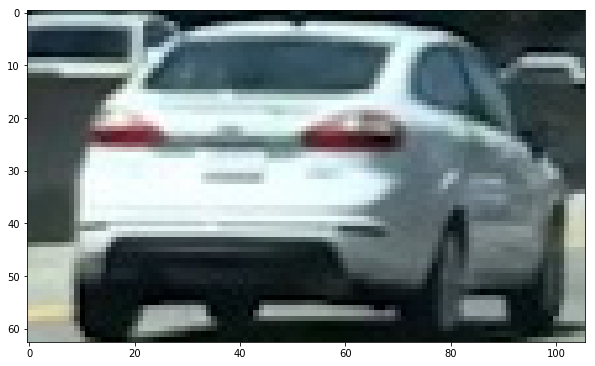

In [7]:
'''Histograms of Color  获取图片颜色分布的特征'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('cutouts/cutout1.jpg')
print(image.shape)
plt.figure(figsize=(10.0, 8.0))
plt.imshow(image)


2
(array([400, 441, 302, 244, 189, 283, 412, 433, 239, 177, 209, 302, 276,
       179, 129, 106, 104, 111, 106,  96, 111, 123, 139, 130, 167, 164,
       149, 156, 222, 268, 258,  53], dtype=int64), array([   0.,    8.,   16.,   24.,   32.,   40.,   48.,   56.,   64.,
         72.,   80.,   88.,   96.,  104.,  112.,  120.,  128.,  136.,
        144.,  152.,  160.,  168.,  176.,  184.,  192.,  200.,  208.,
        216.,  224.,  232.,  240.,  248.,  256.]))
[   4.   12.   20.   28.   36.   44.   52.   60.   68.   76.   84.   92.
  100.  108.  116.  124.  132.  140.  148.  156.  164.  172.  180.  188.
  196.  204.  212.  220.  228.  236.  244.  252.]
(96,)
[400 441 302 244 189 283 412 433 239 177 209 302 276 179 129 106 104 111
 106  96 111 123 139 130 167 164 149 156 222 268 258  53  95 219 441 331
 235 179 188 324 340 321 252 215 242 296 244 198 133 117  98 127  88 120
 104  88 117 172 152 142 133 159 219 589 106 206 367 337 230 174 235 328
 316 238 189 227 261 271 291 244 179 148 134 1

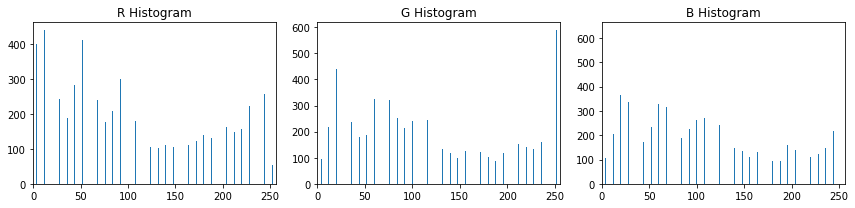

In [8]:
'''计算获得颜色直方图，即颜色分布图'''
# Define a function to compute color histogram features
#定义32个直方块，即0~256的区域分成32块，统计每一块的颜色值个数
''' np.histogram() returns a tuple of two arrays. In this case, for example, 
rhist[0] contains the counts in each of the bins and rhist[1] contains the bin edges
(so it is one element longer than rhist[0]).'''
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0],nbins,bins_range)
    ghist = np.histogram(img[:,:,1],nbins,bins_range)
    bhist = np.histogram(img[:,:,2],nbins,bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0],ghist[0],bhist[0]))#长度为32*3=96的向量，串联
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

print(len(rh))#rhist[0] contains the counts in each of the bins and rhist[1] contains the bin edges
print(rh)
print(bincen)#每个直方块的中心点值
print(feature_vec.shape)#特征向量的大小
print(feature_vec)


# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')


In [9]:
'''获取并查看在不同色彩空间中，颜色值的空间分布'''

'''Explore Color Spaces
You can study the distribution of color values in an image by plotting each pixel in some color space. 
Here's a code snippet that you can use to generate 3D plots:'''

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


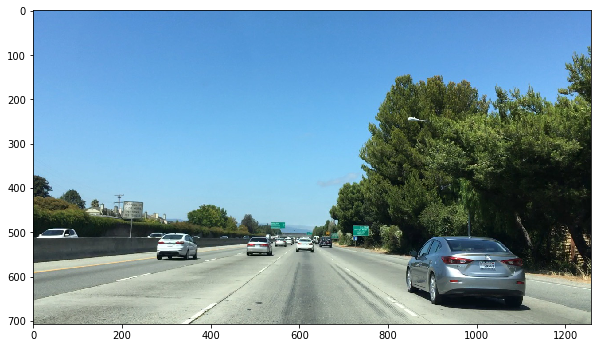

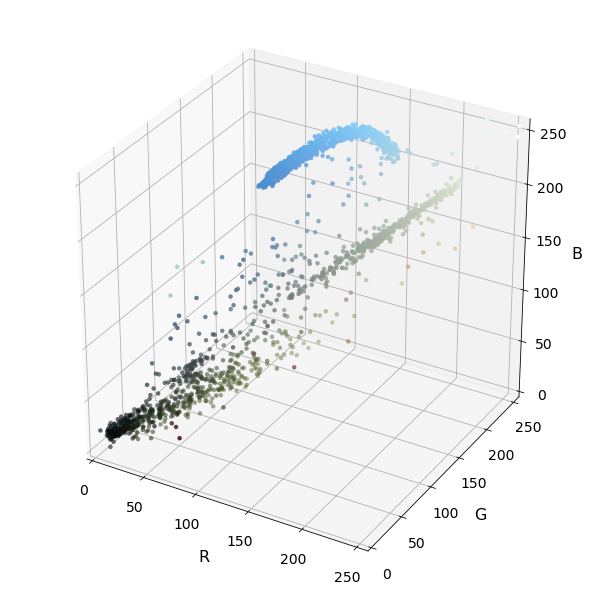

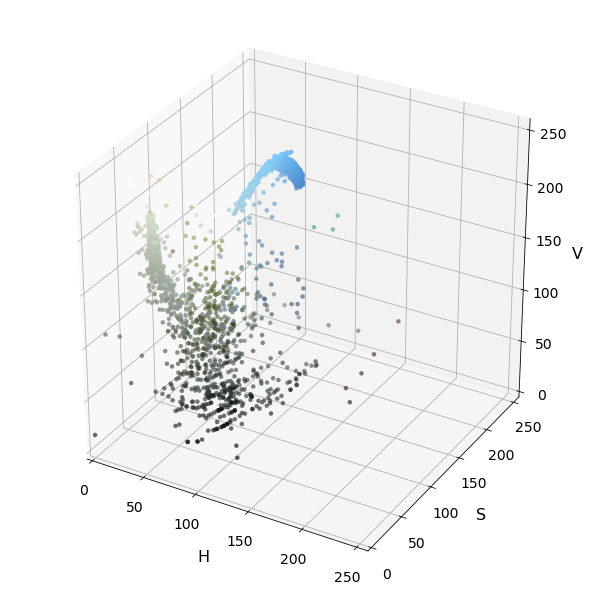

In [10]:
'''Analyze vehicle and non-vehicle images
You might've noticed that it is hard to distinguish between the class of pixels you are interested in (vehicles, in this case) 
from the background.So it may be more beneficial to plot pixels from vehicle and non-vehicle images separately.'''

'''Try experimenting with different color spaces such as LUV or HLS to see 
if you can find a way to consistently separate vehicle images from non-vehicles. 
It doesn't have to be perfect, but it will help when combined with other kinds of features fed into a classifier.'''

# Read a color image
img = cv2.imread("bbox-example-image.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10.0, 8.0))
plt.imshow(img)

img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

(130, 130, 3)


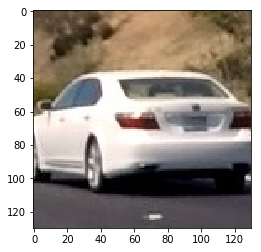

In [12]:
'''Spatial Binning of Color颜色空间划分
可将高分辨率的图片resize成低分辨率的图片，然后获取其颜色值特征向量（不同于前面的颜色值分布特征，分布特征是通过分布直方图获得）'''

'''You saw earlier in the lesson that template matching is not a particularly robust method for finding vehicles 
unless you know exactly what your target object looks like. 
However, raw pixel values are still quite useful to include in your feature vector in searching for cars.

While it could be cumbersome to include three color channels of a full resolution image, 
you can perform spatial binning on an image and still retain enough information to help in finding vehicles.

As you can see in the example above, even going all the way down to 32 x 32 pixel resolution, 
the car itself is still clearly identifiable by eye, 
and this means that the relevant features are still preserved at this resolution.

A convenient function for scaling down the resolution of an image is OpenCV's cv2.resize(). 
You can use it to scale a color image or a single color channel like this:'''


import cv2
import matplotlib.image as mpimg

image = mpimg.imread('test_img.jpg')
print(image.shape)#原始分辨率
plt.imshow(image)

(32, 32, 3)
(3072,)


'Ok, but 3072 elements is still quite a few features! Could you get away with even lower resolution? '

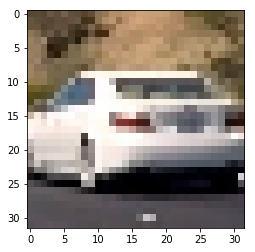

In [14]:
small_img = cv2.resize(image, (32, 32))
print(small_img.shape)#低分辨率图片，依然可以判别出图片中的物体是车辆，可以提取它的颜色特征用于车辆检测
plt.imshow(small_img)


'''If you then wanted to convert this to a one dimensional feature vector, you could simply say something like:'''
feature_vec = small_img.ravel()#将图片值矩阵转换为一维特征向量
print(feature_vec.shape)#32*32*3

'''Ok, but 3072 elements is still quite a few features! Could you get away with even lower resolution? '''

In [15]:
'''Your goal in this exercise is to write a function that takes an image, a color space conversion, 
and the resolution you would like to convert it to, and returns a feature vector. Something like this:'''

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features


(63, 106, 3)
(3072,)


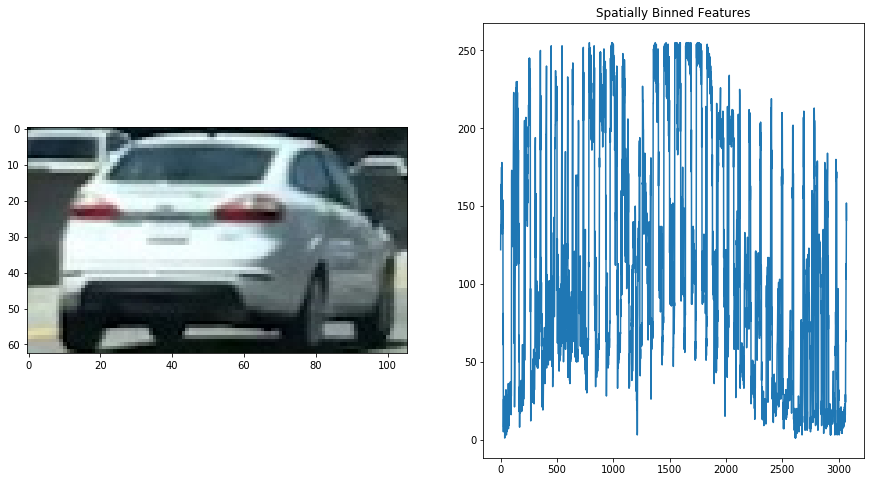

In [17]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('cutouts/cutout1.jpg')
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

fig = plt.figure(figsize=(15,8))
plt.subplot(121)
print(image.shape)
plt.imshow(image)

# Plot features
plt.subplot(122)
print(feature_vec.shape)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')


In [ ]:
'''Gradient Features'''
'''Histogram of Oriented Gradient (HOG) features'''
'''we'll use a relatively small labeled dataset to try out feature extraction and training a classifier. 
Before we get on to extracting HOG features and training a classifier, let's explore the dataset a bit. 
This dataset is a subset of the data you'll be starting with for the project.'''

'''this subset of images for vehicles and non-vehicles'''

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles
images = glob.glob('./cars_smallset/*/*/*/*.jpeg')
#images = glob.glob('./cars_smallset/*.jpeg')
#images = glob.glob(r'C:/Users/bigliu/Desktop/CarND-Vehicle-Detection-master/cars_smallset/*.jpeg')
print(len(images))
#print(images)
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars))
print(len(notcars))

2321
1196
1125


In [19]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img1 = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img1.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img1.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


In [24]:
print(help(np.random.randint))

Help on built-in function randint:

randint(...) method of mtrand.RandomState instance
    randint(low, high=None, size=None, dtype='l')
    
    Return random integers from `low` (inclusive) to `high` (exclusive).
    
    Return random integers from the "discrete uniform" distribution of
    the specified dtype in the "half-open" interval [`low`, `high`). If
    `high` is None (the default), then results are from [0, `low`).
    
    Parameters
    ----------
    low : int
        Lowest (signed) integer to be drawn from the distribution (unless
        ``high=None``, in which case this parameter is one above the
        *highest* such integer).
    high : int, optional
        If provided, one above the largest (signed) integer to be drawn
        from the distribution (see above for behavior if ``high=None``).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, i

714
1091
./cars_smallset\vehicles_smallset\vehicles_smallset\cars2\718.jpeg
./cars_smallset\non-vehicles_smallset\non-vehicles_smallset\notcars3\extra442_19.jpeg


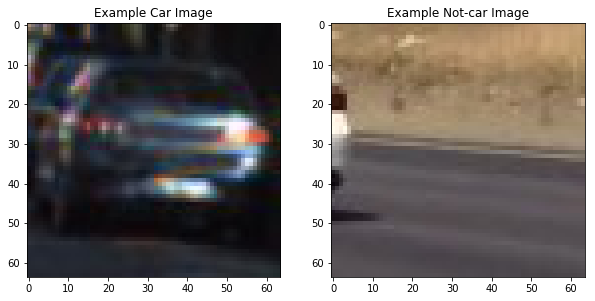

In [20]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
print(car_ind)
print(notcar_ind)

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
print(cars[car_ind])
print(notcars[notcar_ind])

# Plot the examples
fig = plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


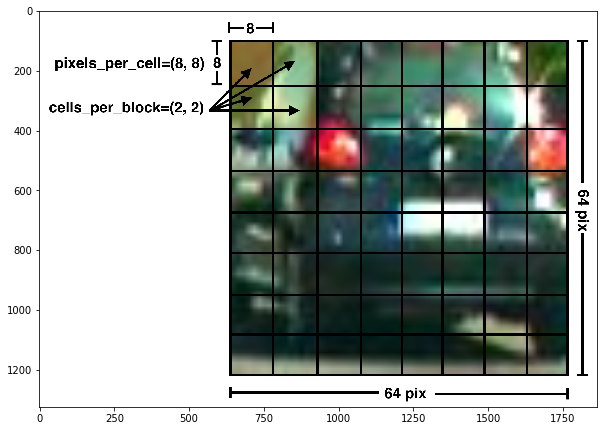

In [21]:

'''scikit-image HOG'''


'''The scikit-image package has a built in function to extract Histogram of Oriented Gradient features. '''
'''The scikit-image hog() function takes in a single color channel or grayscaled image as input, as well as various parameters.
These parameters include orientations, pixels_per_cell and cells_per_block.'''

'''The number of orientations is specified as an integer, and represents the number of orientation bins
that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.'''
'''The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed.
This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.'''
'''The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which 
the histogram counts in a given cell will be normalized. Block normalization is not necessarily required,
but generally leads to a more robust feature set.'''
'''There is another optional power law or "gamma" normalization scheme set by the flag transform_sqrt.
This type of normalization may help reduce the effects of shadows or other illumination variation,
but will cause an error if your image contains negative values (because it's taking the square root of image values).'''

image_hog=mpimg.imread('sci_image_hog.jpeg')
plt.figure(figsize=(10.0, 8.0))
plt.imshow(image_hog)

In [ ]:
'''This is where things get a little confusing though. Let's say you are computing HOG features for an image like the one
shown above that is 64×64 pixels. If you set pixels_per_cell=(8, 8) and cells_per_block=(2, 2) and orientations=9.
How many elements will you have in your HOG feature vector for the entire image?'''

'''You might guess the number of orientations times the number of cells, or 9×8×8=576,
but that's not the case if you're using block normalization! 
In fact, the HOG features for all cells in each block are computed at each block position and
the block steps across and down through the image cell by cell.'''

'''So, the actual number of features in your final feature vector will be the total number of block positions
multiplied by the number of cells per block, times the number of orientations, or in the case shown above:7×7×2×2×9=1764.'''


In [22]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Read in our vehicles
car_images = glob.glob('./cars_smallset/vehicles_smallset/*/*/*.jpeg')
print(len(car_images))        
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
            
    # TODO: Complete the function body and returns
    features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualize=vis, feature_vector=feature_vec,block_norm="L2-Hys",
                          transform_sqrt=False)
    if vis:
        return features, hog_image
    else:
        return features
    

1196


In [31]:
print(help(hog))

Help on function hog in module skimage.feature._hog:

hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm=None, visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
    Extract Histogram of Oriented Gradients (HOG) for a given image.
    
    Compute a Histogram of Oriented Gradients (HOG) by
    
        1. (optional) global image normalization
        2. computing the gradient image in `row` and `col`
        3. computing gradient histograms
        4. normalizing across blocks
        5. flattening into a feature vector
    
    Parameters
    ----------
    image : (M, N[, C]) ndarray
        Input image.
    orientations : int, optional
        Number of orientation bins.
    pixels_per_cell : 2-tuple (int, int), optional
        Size (in pixels) of a cell.
    cells_per_block : 2-tuple (int, int), optional
        Number of cells in each block.
    block_norm : str {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}, optio

(7, 7, 2, 2, 9)
(1764,)


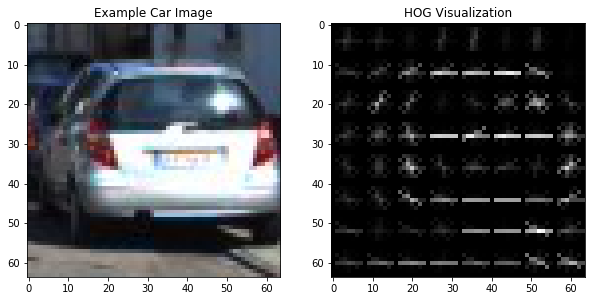

In [23]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
print(features.shape)
print(features.ravel().shape)
# Plot the examples
fig = plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [ ]:
'''If you look at the hog_features output, you'll find it's an array of shape 7×7×2×2×9.
This corresponds to the fact that a grid of 7×7 blocks were sampled, with 2×2 cells in each block and 9 orientations per cell.
You can unroll this array into a feature vector using features.ravel(), which yields, 
in this case, a one dimensional array of length 1764.'''

In [ ]:
'''Combine and Normalize Features'''

'''Now that you've got several feature extraction methods in your toolkit, you're almost ready to train a classifier,
but first, as in any machine learning application, you need to normalize your data.
Python's sklearn package provides you with the StandardScaler() method to accomplish this task. '''

'''To apply StandardScaler() you need to first have your data in the right format, 
as a numpy array where each row is a single feature vector. I will often create a list of feature vectors,
and then convert them like this:'''

import numpy as np
feature_list = [feature_vec1, feature_vec2, ...]
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack(feature_list).astype(np.float64)    
    
它是垂直（按照行顺序）的把数组给堆叠起来


In [37]:
import numpy as np
a=[1,2,3]
b=[4,5,6]
print(np.vstack((a,b)))

[[1 2 3]
 [4 5 6]]


In [38]:
print(help(np.vstack))

Help on function vstack in module numpy.core.shape_base:

vstack(tup)
    Stack arrays in sequence vertically (row wise).
    
    Take a sequence of arrays and stack them vertically to make a single
    array. Rebuild arrays divided by `vsplit`.
    
    This function continues to be supported for backward compatibility, but
    you should prefer ``np.concatenate`` or ``np.stack``. The ``np.stack``
    function was added in NumPy 1.10.
    
    Parameters
    ----------
    tup : sequence of ndarrays
        Tuple containing arrays to be stacked. The arrays must have the same
        shape along all but the first axis.
    
    Returns
    -------
    stacked : ndarray
        The array formed by stacking the given arrays.
    
    See Also
    --------
    stack : Join a sequence of arrays along a new axis.
    hstack : Stack arrays in sequence horizontally (column wise).
    dstack : Stack arrays in sequence depth wise (along third dimension).
    concatenate : Join a sequence of ar

In [39]:
print(help(np.concatenate))

Help on built-in function concatenate in module numpy.core.multiarray:

concatenate(...)
    concatenate((a1, a2, ...), axis=0)
    
    Join a sequence of arrays along an existing axis.
    
    Parameters
    ----------
    a1, a2, ... : sequence of array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int, optional
        The axis along which the arrays will be joined.  Default is 0.
    
    Returns
    -------
    res : ndarray
        The concatenated array.
    
    See Also
    --------
    ma.concatenate : Concatenate function that preserves input masks.
    array_split : Split an array into multiple sub-arrays of equal or
                  near-equal size.
    split : Split array into a list of multiple sub-arrays of equal size.
    hsplit : Split array into multiple sub-arrays horizontally (column wise)
    vsplit : Split array into multiple sub-arrays vertically (row wise)
    dsp

In [24]:
'''将不同种类的特征标准化后再联合在一起'''
'''这里将颜色值特征，与颜色值分布直方图特征，联合在一起'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

#将img转换为指定尺寸，并拉平为行向量
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()#32*32*3=3072 
    # Return the feature vector
    return features

#获取色彩空间每个通道上的颜色值直方图
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    #将3个通道上的直方图值串联在一起
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features#32*3=96

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        img= mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if cspace == 'BGR':
            img = cv2.cvtColor(img,COLOR_RGB2BGR)
        elif cspace == 'HSV':
            img = cv2.cvtColor(img,COLOR_RGB2HSV)
        elif cspace == 'HSL':
            img = cv2.cvtColor(img,COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img = cv2.cvtColor(img,COLOR_RGB2YUV)
        else:
            img = np.copy(img)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(img, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(img, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))#3072+96=3168
        
    # Return list of feature vectors    
    return features


2321
1196
1125
............
1196
3168
[ 39  35  42 ...,  66  61 119]
............
1125
3168
[112 146 180 ...,   0   0   0]
............
(2321, 3168)
[  39.   35.   42. ...,   66.   61.  119.]
............
210
(3168,)
[  47.   43.   15. ...,   93.  119.  368.]
[-0.62209966 -0.72629323 -1.13825485 ...,  2.058431    2.02089556
  1.68400606]


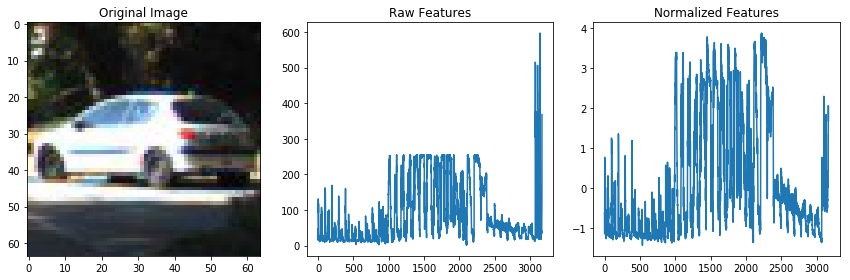

In [25]:
images = glob.glob('./cars_smallset/*/*/*/*.jpeg')
print(len(images))
#print(images)

cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars))
print(len(notcars))
print('............')

car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
print(len(car_features))
print(len(car_features[0]))
print(car_features[0])
print('............')
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
print(len(notcar_features))
print(len(notcar_features[0]))
print(notcar_features[0])
print('............')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)#vstack : Stack arrays in sequence vertically (row wise).
    print(X.shape)#打印垂直堆叠后的特征矩阵大小
    print(X[0])#打印第一行
    print('............')
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    car_ind = np.random.randint(0, len(cars))
    print(car_ind)
    print(X[car_ind].shape)
    print(X[car_ind])
    print(scaled_X[car_ind])
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')
    

In [5]:
print(help(np.hstack))#hstack : Stack arrays in sequence horizontally (column wise)

Help on function hstack in module numpy.core.shape_base:

hstack(tup)
    Stack arrays in sequence horizontally (column wise).
    
    Take a sequence of arrays and stack them horizontally to make
    a single array. Rebuild arrays divided by `hsplit`.
    
    This function continues to be supported for backward compatibility, but
    you should prefer ``np.concatenate`` or ``np.stack``. The ``np.stack``
    function was added in NumPy 1.10.
    
    Parameters
    ----------
    tup : sequence of ndarrays
        All arrays must have the same shape along all but the second axis.
    
    Returns
    -------
    stacked : ndarray
        The array formed by stacking the given arrays.
    
    See Also
    --------
    stack : Join a sequence of arrays along a new axis.
    vstack : Stack arrays in sequence vertically (row wise).
    dstack : Stack arrays in sequence depth wise (along third axis).
    concatenate : Join a sequence of arrays along an existing axis.
    hsplit : Split a

In [7]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))
print(y.shape)#列表水平堆叠后，是个行向量
print(y)

(2321,)
[ 1.  1.  1. ...,  0.  0.  0.]


# SVM Hyperparameters
In the SVM lesson, Katie mentioned optimizing the Gamma and C parameters.

Successfully tuning your algorithm involves searching for a kernel, a gamma value and a C value that minimize prediction error.
To tune your SVM vehicle detection model, you can use one of scikit-learn's parameter tuning algorithms.

When tuning SVM, remember that you can only tune the C parameter with a linear kernel.
For a non-linear kernel, you can tune C and gamma.

Color Classify

Now we'll try training a classifier on our dataset. First, we'll see how well it does just using spatially binned color and color histograms.

To do this, we'll use the functions you defined in previous exercises, namely, bin_spatial(), color_hist(), and extract_features(). We'll then read in our car and non-car images, and extract the color features for each.

All that remains is to define a labels vector, shuffle and split the data into training and testing sets, scale the feature vectors to zero mean and unit variance, and finally, define a classifier and train it!

In [ ]:
Our labels vector y in this case will just be a binary vector indicating whether each feature vector 
in our dataset corresponds to a car or non-car (1's for cars, 0's for non-cars). 
Given lists of car and non-car features (the output of extract_features()) we can define a labels vector like this:
import numpy as np
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

In [ ]:
And now we're ready to shuffle and split the data into training and testing sets. 
To do this we'll use the Scikit-Learn train_test_split() function, but it's worth noting that recently,
this function moved from the sklearn.cross_validation package (in sklearn version <=0.17)
to the sklearn.model_selection package (in sklearn version >=0.18).

In the quiz editor we're still running sklearn v0.17, so we'll import it like this:
from sklearn.cross_validation import train_test_split
# But, if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split

train_test_split() performs both the shuffle and split of the data and you'll call it like this
(here choosing to initialize the shuffle with a different random state each time):
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

Warning: when dealing with image data that was extracted from video, you may be dealing with sequences of images where your target object (vehicles in this case) appear almost identical in a whole series of images. In such a case, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set. For the subset of images used in the next several quizzes, this is not a problem, but to optimize your classifier for the project, you may need to worry about time-series of images!

In [ ]:
Now that we have split into training and test sets, we can scale our features. 
It's important to do the scaling after splitting the data, otherwise you are allowing the scaler to peer into your test data!

from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [ ]:
Now, you're ready to define and train a classifier! Here we'll try a Linear Support Vector Machine. 
To define and train your classifier it takes just a few lines of code:

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(scaled_X_train, y_train)

Then you can check the accuracy of your classifier on the test dataset like this:
print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))

Or you can make predictions on a subset of the test data and compare directly with ground truth:
print('My SVC predicts: ', svc.predict(scaled_X_test[0:10].reshape(1, -1)))
print('For labels: ', y_test[0:10])



In [ ]:
'''这里使用bin_spatial，color_hist两种特征来训练线性SVC'''

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


In [27]:
# Read in car and non-car images
images = glob.glob('./cars_smallset/*/*/*/*.jpeg')
print(len(images))
#print(images)

cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars))
print(len(notcars))
print('.............')

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
print(len(car_features))
print(len(car_features[0]))
print(car_features[0])
print('.............')
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
print(len(notcar_features))
print(len(notcar_features[0]))
print(notcar_features[0])
print('.............')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X.shape)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print(y.shape)
print('.............')
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train),4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2321
1196
1125
.............
1196
3168
[ 39  35  42 ...,  66  61 119]
.............
1125
3168
[112 146 180 ...,   0   0   0]
.............
(2321, 3168)
(2321,)
.............
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
2.36 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9785
My SVC predicts:  [ 0.  1.  0.  1.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  1.  0.  1.  0.  0.]
0.004 Seconds to predict 10 labels with SVC


In [ ]:
HOG Classify
使用HOG特征来训练分类器
Alright, so classification by color features alone is pretty effective! 
Now let's try classifying with HOG features and see how well we can do.

In [ ]:
In the exercise below, you're given all the code to extract HOG features and train a linear SVM.
There is no right or wrong answer, but your mission, should you choose to accept it, 
is to play with the parameters colorspace, orient, pix_per_cell, cell_per_block, 
and hog_channel to get a feel for what combination of parameters give the best results.

Note: hog_channel can take values of 0, 1, 2, or "ALL", 
meaning that you extract HOG features from the first, second, third, or all color channels respectively.

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [29]:
# Read in car and non-car images
images = glob.glob('./cars_smallset/*/*/*/*.jpeg')
print(len(images))
#print(images)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars))
print(len(notcars))        
print('.............')               
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train),4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2321
1196
1125
.............


D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


12.35 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.26 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.99
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  1.  0.  1.  1.]
0.003 Seconds to predict 10 labels with SVC


# Sliding Windows

To implement a sliding window search, you need to decide what size window you want to search,
where in the image you want to start and stop your search, and how much you want windows to overlap.
So, let's try an example to see how many windows we would be searching given a particular image size, window size, and overlap.

In [ ]:
General Formula:
windows_x = 1 + (image_width - window_width)/(window_width * overlap_proportion)
windows_y = 1 + (image_height - window_height)/(window_height * overlap_proportion)
total_windows = windows_x * windows_y

In [ ]:
Suppose you have an image that is 1280 x 960 pixels and you want to search the entire image using 64 x 64 pixel windows
with 50% overlap between windows in both the vertical and horizontal directions.
How many windows would you be searching total?

x: The first window occupies 64 pixels, then moves over by 32 pixels to cover the remaining (1280 - 64) pixel span.
    1 + (1280 - 64)/32 = 39
y: The first window occupies 64 pixels and then moves over by 32 pixels to cover the remaining span of (960 - 64) pixels.
    1 + (960/32) = 29
Note that the denominator originates from 64 * 0.5, since we have 50% overlap.
39 * 29 = 1131


In [ ]:
Sliding Window Implementation

In the last exercise, you saw how the number of windows scales with image size, window size, and overlap. 
In the project it will be useful to have a function to perform a sliding window search on an image, so let's write one!
This will just be the first iteration, 
where you don't actually need to do anything besides plot a rectangle at each window position.

So, your goal here is to write a function that takes in an image, 
start and stop positions in both x and y (imagine a bounding box for the entire search region),
window size (x and y dimensions), and overlap fraction (also for both x and y).
Your function should return a list of bounding boxes for the search windows,
which will then be passed to draw draw_boxes() function.

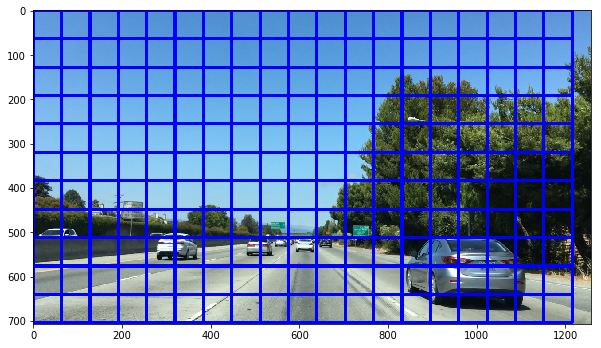

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
'''定义一个实现滑窗功能的函数'''    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    xpixel_per_step = np.int(xy_window[0] * (1-xy_overlap[0]))
    ypixel_per_step = np.int(xy_window[1] * (1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * xy_overlap[0])
    ny_buffer = np.int( xy_window[1] * xy_overlap[1])
    
    #x_windows = np.int((x_span - nx_buffer)/xpixel_per_step)
    #y_windows = np.int((y_span - ny_buffer)/ypixel_per_step)
    x_windows = 1+np.int((x_span - xy_window[0])/xpixel_per_step)
    y_windows = 1+np.int((y_span - xy_window[1])/ypixel_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for y_window in range(y_windows):
        for x_window in range(x_windows):
            # Calculate each window position
            x_start = x_window * xpixel_per_step + x_start_stop[0]
            x_end = x_start + xy_window[0]
            y_start = y_window * ypixel_per_step + y_start_stop[0]     
            y_end = y_start + xy_window[1]
            # Append window position to list
            window_list.append(((x_start,y_start),(x_end, y_end)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=2)
plt.figure(figsize=(10,8))
plt.imshow(window_img)

In [ ]:
Now you're able to run a sliding window search on an image and you've trained a classifier...
time to combine both steps and search for cars!

You already have all the tools you need to do this from the previous exercises. Just train your classifier,
then run your sliding window search, extract features, and predict whether each window contains a car or not.
You'll probably find some false positives, but soon we'll deal with removing them.


In the lesson_functions.py tab on the quiz editor, you'll find all the functions we've defined so far in the lesson,
including get_hog_features(), bin_spatial(), color_hist(), extract_features(), slide_window(), and draw_boxes().

Two new functions are defined: single_img_features() and search_windows(). 
You can use these to search over all the windows defined by your slide_windows(), 
extract features at each window position, and predict with your classifier on each set of features.

In this exercise, experiment with different color and gradient feature sets, different search window sizes and overlap
to get an idea of how your classifier performs with different training features.
Getting false positives in the skies and treetops? 
Try restricting your search area on the image with y_start_stop in the slide_window() function.
What combination of features works best?


In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
%matplotlib inline

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
       

2321
1196
1125


D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5388
0.26 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.985


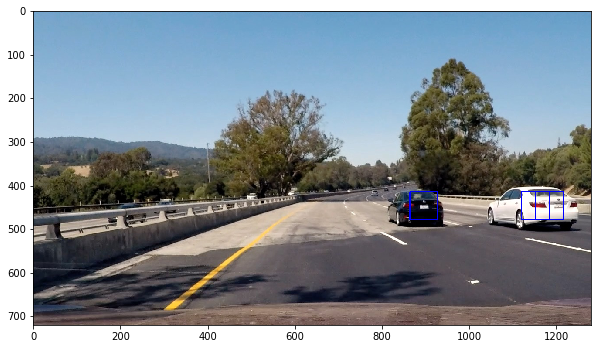

In [33]:
# Read in car and non-car images
images = glob.glob('./cars_smallset/*/*/*/*.jpeg')
print(len(images))
#print(images)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars))
print(len(notcars))


# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [None, None] # Min and max in y to search in slide_window()
y_start_stop = [350,None]
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train),4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


# Check the prediction time for a single sample
t=time.time()

#image = mpimg.imread('bbox-example-image.jpg')
image = mpimg.imread('test_image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    
plt.figure(figsize=(10.0, 8.0))
plt.imshow(window_img)


In [34]:
'''保存训练好的分类器'''
import pickle

# Save the svc classifier result for later use 
dist_pickle = {}

dist_pickle["svc"]=svc
dist_pickle["scaler"]=X_scaler
dist_pickle["orient"]=orient
dist_pickle["pix_per_cell"]=pix_per_cell
dist_pickle["cell_per_block"]=cell_per_block
dist_pickle["spatial_size"]=spatial_size
dist_pickle["hist_bins"]=hist_bins

pickle.dump( dist_pickle, open( "svc_pickle_myself.p", "wb" ) )


Hog Sub-sampling Window Search

Now lets explore a more efficient method for doing the sliding window approach,
one that allows us to only have to extract the Hog features once. 
The code below defines a single function find_cars that's able to both extract features and makepredictions.

The find_cars only has to extract hog features once, for each of a small set of predetermined window sizes (defined by a scale argument), and then can be sub-sampled to get all of its overlaying windows.
Each window is defined by a scaling factor that impacts the window size. The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center).

For our example are using a 64 x 64 base window. If we define cells per pixel as 8 x 8,
then a scale of 1 would retain a window that's 8 x 8 cells (8 cells to cover 64 pixels in either direction).
An overlap of each window can be defined in terms of the cell distance, using cells_per_step.
This means that a cells_per_step = 2 would result in a search window overlap of 75% (2 is 25% of 8, so we move 25% each time, leaving 75% overlap with the previous window). 
Any value of scale that is larger or smaller than one will scale the base image accordingly, resulting in corresponding change in the number of cells per window. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

上一个函数是每一个滑动窗口都要进行特征提取，但是相邻窗口之间存在重叠区域，每个窗口都要进行一次特征提取，那么重叠部分就会被多次提取，降低了运行效率。
这个所谓的子采样窗口查询，就是先对整张图片进行一次特征提取，然后各个滑动窗口根据位置提取特征，避免了重叠区域的重复提取，因此提高了效率。另外，函数中定义了一个滑动窗口缩放因子，可进行多尺度的滑动窗口查询。


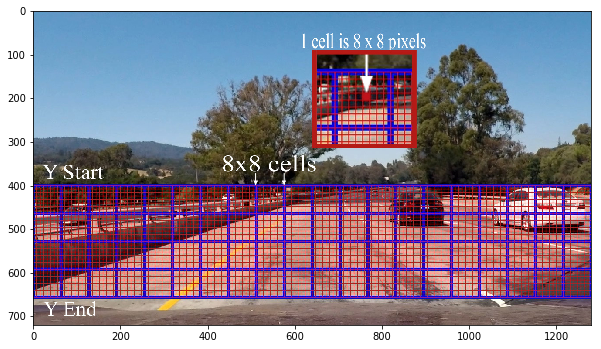

In [35]:
image = mpimg.imread('sub-sampling-windon-search.jpg')
plt.figure(figsize=(10.0, 8.0))
plt.imshow(image)

D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator LinearSVC from version pre-0.18 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator StandardScaler from version pre-0.18 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


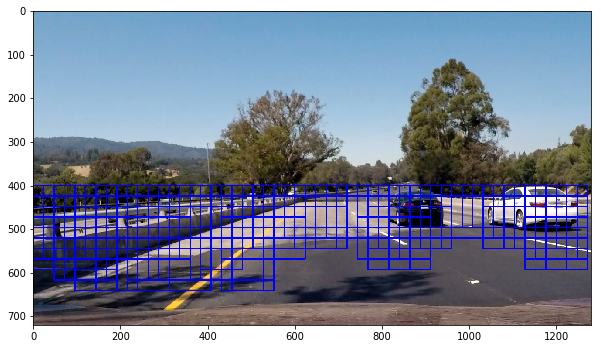

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *
%matplotlib inline
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255#归一化
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),2) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.figure(figsize=(10.0, 8.0))
plt.imshow(out_img)

(720, 1280)


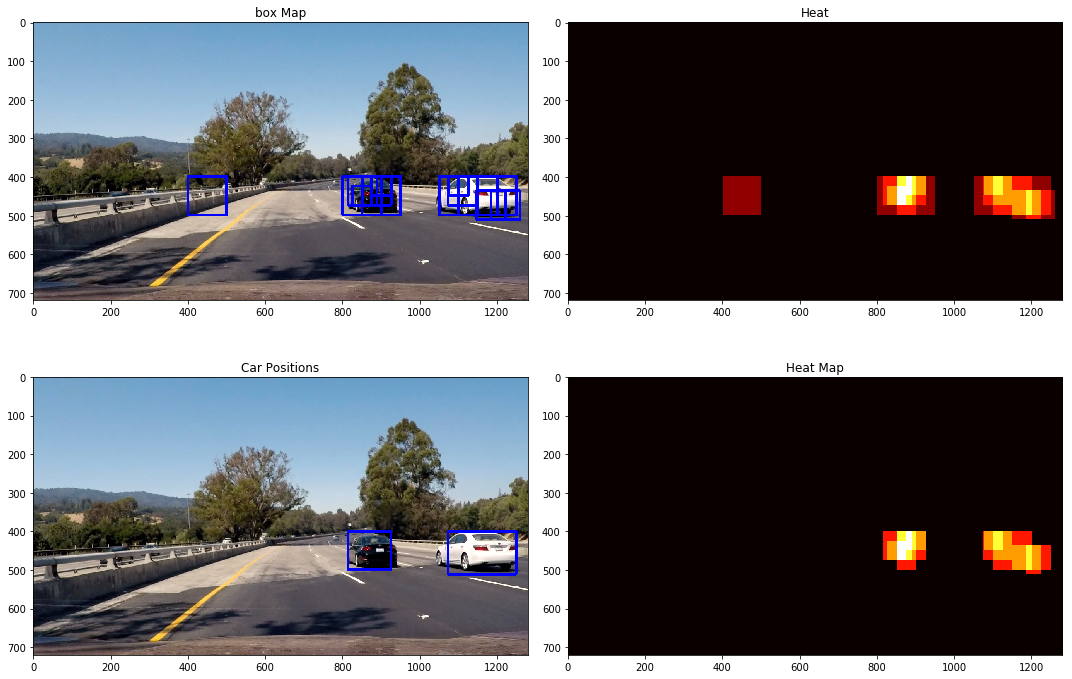

In [38]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
print(heat.shape)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_boxes(img, box_list):
    # Iterate through all detected 
    for box in box_list:
        # Define a bounding box based on min/max x and y
        # Draw the box on the image
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
    # Return the image
    return img



# Add heat to each box in box list
heat = add_heat(heat,box_list)
draw_box=draw_boxes(np.copy(image), box_list)
fig = plt.figure(figsize=(15.0, 10.0))
plt.subplot(221)
plt.imshow(draw_box)
plt.title('box Map')
plt.subplot(222)
plt.imshow(heat,cmap='hot')
plt.title('Heat')

# Apply threshold to help remove false positives
threshold_heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(threshold_heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plt.subplot(223)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(224)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [42]:
# import libs
import glob
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import pickle
SEED = 2018
%matplotlib inline
# Read dataset image
vehicle_images = glob.glob('./vehicles/*/*/*.png')
none_vehicle_images = glob.glob('./non-vehicles/*/*/*.png')
cars = []
notcars = []
for image in vehicle_images:
    cars.append(image)
for image in none_vehicle_images:
    notcars.append(image)
print('Dataset size:Cars {} | NotCars {}'.format(len(cars),len(notcars)))
rate = len(cars)/len(notcars)*1.0
if rate<2 and rate>0.5:
    print('DataSet is balance')
else:
    print('DataSet is not balance')

Dataset size:Cars 8792 | NotCars 8968
DataSet is balance


The size of car is 64
The size of notcar is 64


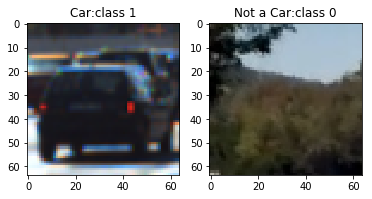

In [43]:
# random choose
rand_car = np.random.choice(len(cars))
rand_notcar = np.random.choice(len(notcars))
this_car = mpimg.imread(cars[rand_car])
this_notcar = mpimg.imread(notcars[rand_notcar])

print('The size of car is {}'.format(len(this_car)))
print('The size of notcar is {}'.format(len(this_notcar)))
plt.figure(1)
plt.subplot(121)
plt.title('Car:class 1')
plt.imshow(this_car)
plt.subplot(122)
plt.title('Not a Car:class 0')
plt.imshow(this_notcar)
plt.show()

In [ ]:
## 
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    '''
    function:Extract HOG image and HOG features of a given image
    orient: number of bins for the orientation
    pix_per_cell: size of a cell
    cell_per_block: nber of cells per block
    vis(Boolean) :visualize the HOG image
    feature_vec(Boolean):return the features as a feature vector
    By default,the function uses transform_sqrt(apply power law compression to normalize the image before processing)
    '''
    if vis == True:
        features,hog_image = hog(img,orientations=orient,
                                pixels_per_cell=(pix_per_cell,pix_per_cell),
                                cells_per_block = (cell_per_block,cell_per_block),
                                transform_sqrt=True,
                                visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    else:
        features = hog(img,orientations=orient,
                       pixels_per_cell=(pix_per_cell,pix_per_cell),
                      cells_per_block=(cell_per_block,cell_per_block),
                      transform_sqrt=True,
                      visualise=vis,feature_vector=feature_vec)
        return features

def bin_spatial(img,size=(32,32)):
    '''
    Binned Color Feature
    img:original image
    size:target size of the image
    output:feature vector
    '''
    features = cv2.resize(img,size).ravel()
    #print(cv2.resize(img,size).shape)(8,8,3)=>192
    return features

def color_hist(img,nbins=32,bins_range=(0,256)):
    '''
    Color histogram features for each channel of the original image
    img: original image
    nbins: number of bins of the histogram
    output:concatenate feature vector
    '''
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    #Concatenate the histograms into a sigle feature vector
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))#48
    #print(channel1_hist)
    # Return the individual histograms into a single feature vector 
    return hist_features

def extract_features(imgs,color_space="RGB",spatial_size=(32,32),
                    hist_bins=32,orient=9,
                    pix_per_cell=8,cell_per_block=2,hog_channel=0,
                    spatial_feat=True,hist_feat=True,hog_feat=True,
                    hog_vis=False):
    '''
    Feature extractor:extract features from a list of images
    The function calls bin_spatial(),color_hist() and get_hog_features
    '''
    #create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if hog_vis == False:
            image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        # color conversion
        if color_space in ['HSV','LUV','HLS','YUV','YCrCb']:
            feature_image = cv2.cvtColor(image,eval('cv2.COLOR_RGB2'+color_space))
        else: feature_image = np.copy(image)
        # Image size: add all pixels of reduced image as vector
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image,size=spatial_size)
            #print('spatial features shape:',spatial_features.shape)
            file_features.append(spatial_features)
        # Histogram of reduced image: add histogram as a vector
        if hist_feat == True:
            hist_features = color_hist(feature_image,nbins=hist_bins)
            file_features.append(hist_features)
        #HOG of reduced image: add HOG as feature vector
        if hog_feat == True:# Call get_hog_features() with vis=False ,feature_vec = True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    if hog_vis:
                        hog_feature,hog_image = get_hog_features(feature_image[:,:,channel],
                                                                orient,pix_per_cell,cell_per_block,
                                                                vis=True,feature_vec=True)
                        #print(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY).dtype)
                        res = cv2.addWeighted(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY),0.1,
                                              ((hog_image/np.max(hog_image))*255).astype(np.float32),0.1,0.0)
                        # Plot the examples
                        fig = plt.figure()
                        plt.title(channel)
                        plt.subplot(131)
                        plt.imshow(image,cmap='gray')
                        plt.title('Original Image')
                        plt.subplot(132)
                        plt.imshow(hog_image,cmap='gray')
                        plt.title('HOG')
                        plt.subplot(133)
                        plt.imshow(res,cmap='gray')
                        plt.title('overlapped')
                        plt.show()
                    else:
                        hog_feature = get_hog_features(feature_image[:,:,channel],
                                                      orient,pix_per_cell,cell_per_block,
                                                      vis=False,feature_vec=True)
                    #print('hog feature shape:',hog_feature.shape)
                    hog_features.append(hog_feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,
                                               pix_per_cell,cell_per_block,vis=False,feature_vec = True)
            #Append the new feature vector to the features list
            #print('hog features shape:',hog_features.shape)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        #print(np.concatenate(file_features).shape)
    # return list of feature vectors
    return features